In [1]:
import torch 
import torch_geometric as pyg
import pandas as pd
import numpy as np
import omnipath as op 
from matplotlib import pyplot as plt 
import torch_geometric as pyg 
import copy 
import umap
from sklearn.decomposition import PCA
import seaborn as sbn

from gsnn.reinforce.Actor import Actor
from gsnn.reinforce.Environment import Environment
from gsnn.models.GSNN import GSNN
from gsnn.data.LincsDataset import LincsDataset
from gsnn.models import utils 
from gsnn.proc.utils import get_x_drug_conc             # required to unpickle data 

%load_ext autoreload
%autoreload 2

/home/teddy/miniconda3/envs/gsnn/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [43]:

result_dict = torch.load('../../processed_data/rl_results_dict.pt')
NS = result_dict['actor']
NS.load_state_dict(result_dict['state_dict'])
data = torch.load('../../data/all/data.pt')

row,col = data.edge_index_dict['function','to','function'].detach().cpu().numpy()
N = len(row)

uni2sym = pd.read_csv('../../extdata/omnipath_uniprot2genesymb.tsv', sep='\t')

res = pd.DataFrame({'src':np.array(data.node_names_dict['function'])[row], 
                    'dst':np.array(data.node_names_dict['function'])[col],
                    'prob':result_dict['node_prob'].ravel()})
res = res.assign(src_from=lambda x: [xx.split('__')[1] for xx in x.src])
res = res.assign(dst_from=lambda x: [xx.split('__')[1] for xx in x.dst])
res = res.merge(uni2sym, left_on='src_from', right_on='From', how='left')
res = res.merge(uni2sym, left_on='dst_from', right_on='From', how='left')
res = res.drop(['From_x', 'From_y', 'src_from', 'dst_from'], axis=1).rename({'To_x': 'src_uniprot', 'To_y':'dst_uniprot'}, axis=1)

#_ = [print(x) for x in res.sort_values('prob', ascending=False).dropna().head(50).To.tolist()]

res.sort_values('prob', ascending=False).head(20)

,src,dst,prob,src_uniprot,dst_uniprot
16758,PROTEIN__P22004,PROTEIN__O00238,1.0,BMP6,BMPR1B
88285,RNA__Q7Z6G8,PROTEIN__Q7Z6G8,1.0,ANKS1B,ANKS1B
16230,PROTEIN__O43921,PROTEIN__P54756,1.0,EFNA2,EPHA5
29579,PROTEIN__P48039,PROTEIN__P27797,1.0,MTNR1A,CALR
85530,RNA__Q5S007,PROTEIN__Q5S007,1.0,LRRK2,LRRK2
28591,PROTEIN__O14625,PROTEIN__P27487,1.0,CXCL11,DPP4
80126,RNA__MIMAT0000265,RNA__P15311,1.0,NaN,EZR
31007,PROTEIN__P11836,PROTEIN__P19397,1.0,MS4A1,CD53
39801,PROTEIN__O14966,PROTEIN__Q5S007,1.0,RAB29,LRRK2
60259,PROTEIN__Q9UI95,PROTEIN__Q9BS18,1.0,MAD2L2,ANAPC13


In [44]:
edges_to_tp53_rna = res[lambda x: x.dst == 'RNA__P04637']
edges_to_tp53_rna.sort_values('prob', ascending=False).head(20)

,src,dst,prob,src_uniprot,dst_uniprot
79552,RNA__MIMAT0000443,RNA__P04637,0.981434,NaN,TP53
77499,RNA__MIMAT0004602,RNA__P04637,0.890051,NaN,TP53
77760,RNA__MIMAT0000757,RNA__P04637,0.782920,NaN,TP53
81371,RNA__MIMAT0005583,RNA__P04637,0.759337,NaN,TP53
78656,RNA__MIMAT0009203,RNA__P04637,0.737397,NaN,TP53
78468,RNA__MIMAT0004676,RNA__P04637,0.720975,NaN,TP53
78372,RNA__MIMAT0004674,RNA__P04637,0.683483,NaN,TP53
3775,PROTEIN__P35712,RNA__P04637,0.658002,SOX6,TP53
78367,RNA__MIMAT0004550,RNA__P04637,0.626902,NaN,TP53
78374,RNA__MIMAT0000693,RNA__P04637,0.595095,NaN,TP53


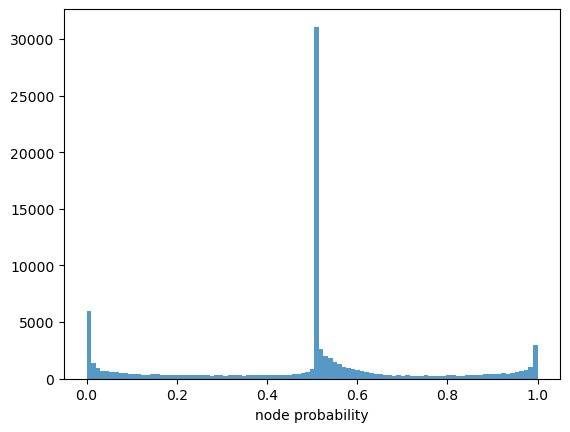

In [45]:

plt.figure()
plt.hist(res.prob, bins=np.linspace(0,1,100), alpha=0.75)
#for i,row in edges_to_tp53_rna.iterrows(): 
#    plt.axvline(row.prob, c='g')
plt.xlabel('node probability')
plt.show()

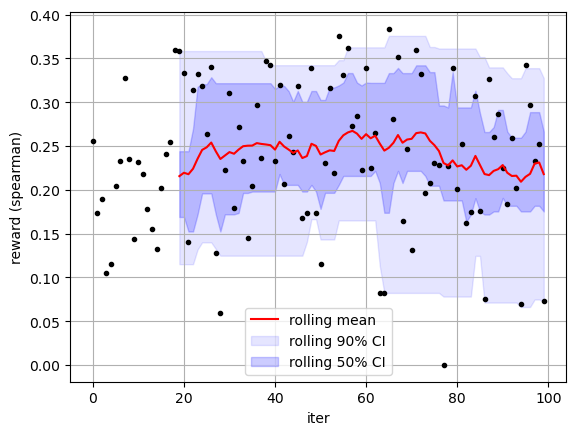

In [46]:
window=20
tmp = pd.DataFrame({'reward':result_dict['reward_scaler'].rewards})
tmp = tmp.assign(rm = tmp.rolling(window=window).mean(), 
                 rs = tmp.rolling(window=window).std(),
                 q05 = tmp.rolling(window=window).quantile(q=0.05),
                 q25 = tmp.rolling(window=window).quantile(q=0.25), 
                 q75 = tmp.rolling(window=window).quantile(q=0.75), 
                 q95 = tmp.rolling(window=window).quantile(q=0.95), 
                 )

plt.figure()
plt.plot(result_dict['reward_scaler'].rewards, 'k.')
plt.plot(tmp.rm, 'r-', label='rolling mean')
plt.fill_between(range(len(tmp.rm)), tmp.q95, tmp.q05, color='b', alpha=0.1, label='rolling 90% CI')
plt.fill_between(range(len(tmp.rm)), tmp.q75, tmp.q25, color='b', alpha=0.2, label='rolling 50% CI')
plt.legend()
plt.grid()
plt.xlabel('iter')
plt.ylabel('reward (spearman)')
plt.show()

/home/teddy/miniconda3/envs/gsnn/lib/python3.12/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


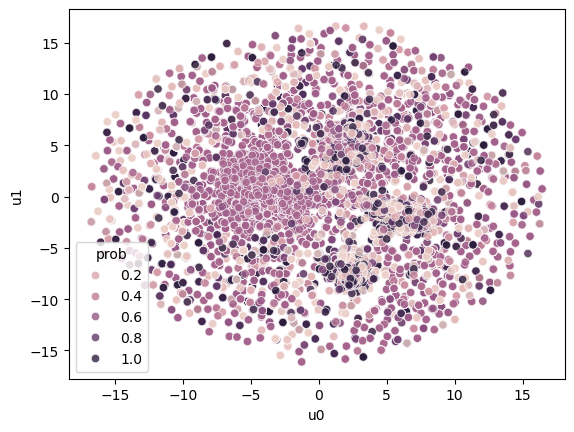

In [26]:
z = result_dict['x'].detach().cpu().numpy() 
reducer = umap.UMAP(n_neighbors=15, min_dist=0.1)
#reducer = PCA(n_components=2)
u = reducer.fit_transform(z)

zres = pd.DataFrame(u, columns=['u0', 'u1']).assign(prob=result_dict['node_prob'])

plt.figure()
sbn.scatterplot(x='u0', y='u1', hue='prob', data=zres, alpha=0.8)
plt.show()

In [72]:
result_dict = torch.load('../../processed_data/rl_results_dict.pt')
NS = result_dict['actor']
NS.load_state_dict(result_dict['state_dict'])
data = torch.load('../../data/all/data.pt')

row,col = data.edge_index_dict['function','to','function']
N = len(data.node_names_dict['function'])
iD = pyg.utils.degree(row, num_nodes=N).detach().cpu().numpy()
oD = pyg.utils.degree(col, num_nodes=N).detach().cpu().numpy()
D = iD + oD

uni2sym = pd.read_csv('../../extdata/omnipath_uniprot2genesymb.tsv', sep='\t')

res = pd.DataFrame({'node_name':data.node_names_dict['function'], 'prob':result_dict['node_prob'].ravel(), 'degree':D, 'in_degree':iD, 'out_degree':oD})
res = res.assign(From=lambda x: [xx.split('__')[1] for xx in x.node_name])
res = res.merge(uni2sym, on='From', how='left')

#_ = [print(x) for x in res.sort_values('prob', ascending=False).dropna().head(50).To.tolist()]

res.sort_values('prob', ascending=False).head(10)

,node_name,prob,degree,in_degree,out_degree,From,To
4684,PROTEIN__Q9H0R8,0.514116,9.0,4.0,5.0,Q9H0R8,GABARAPL1
1053,PROTEIN__P04150,0.514116,161.0,88.0,73.0,P04150,NR3C1
5849,RNA__MIMAT0004694,0.514116,6.0,3.0,3.0,MIMAT0004694,NaN
2766,PROTEIN__P78549,0.514116,4.0,1.0,3.0,P78549,NTHL1
1061,PROTEIN__P04233,0.514116,15.0,4.0,11.0,P04233,CD74
2767,PROTEIN__P78552,0.514116,20.0,5.0,15.0,P78552,IL13RA1
5838,RNA__MIMAT0004677,0.514116,29.0,23.0,6.0,MIMAT0004677,NaN
8015,RNA__Q13332,0.514116,2.0,1.0,1.0,Q13332,PTPRS
5832,RNA__MIMAT0004671,0.514116,9.0,3.0,6.0,MIMAT0004671,NaN
1054,PROTEIN__P04155,0.514116,27.0,11.0,16.0,P04155,TFF1


In [67]:
res.sort_values('prob', ascending=False).tail(10)

,node_name,prob,degree,in_degree,out_degree,From,To
3552,PROTEIN__Q16829,0.042645,14.0,10.0,4.0,Q16829,DUSP7
394,PROTEIN__O14818,0.042553,33.0,27.0,6.0,O14818,PSMA7
2381,PROTEIN__P49915,0.042312,3.0,2.0,1.0,P49915,GMPS
7656,RNA__P61587,0.041962,9.0,1.0,8.0,P61587,RND3
5966,RNA__MIMAT0031890,0.041753,23.0,10.0,13.0,MIMAT0031890,NaN
9117,RNA__Q9P253,0.041511,2.0,1.0,1.0,Q9P253,VPS18
2625,PROTEIN__P60896,0.040673,29.0,28.0,1.0,P60896,SEM1
4852,PROTEIN__Q9NQ30,0.039327,3.0,1.0,2.0,Q9NQ30,ESM1
6806,RNA__P13726,0.039012,8.0,1.0,7.0,P13726,F3
1743,PROTEIN__P22735,0.037152,7.0,6.0,1.0,P22735,TGM1


: 

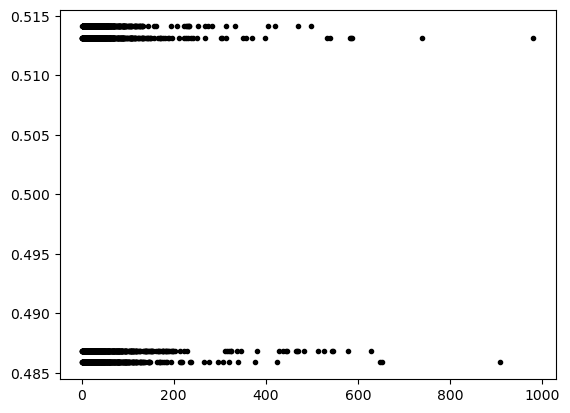

In [73]:
plt.figure()
plt.plot(res.degree, res.prob, 'k.')
plt.show()

In [74]:
row,col = data.edge_index_dict['input', 'to', 'function']
dti_idxs = col[row == 0] # 'DRUG__BRD-K60230970'
targs = np.array(data.node_names_dict['function'])[dti_idxs]
res[lambda x: x.node_name.isin(targs)].sort_values('prob', ascending=False)

,node_name,prob,degree,in_degree,out_degree,From,To
767,PROTEIN__O94804,0.514116,9.0,3.0,6.0,O94804,STK10
1182,PROTEIN__P07948,0.514116,252.0,193.0,59.0,P07948,LYN
4593,PROTEIN__Q9BX84,0.514116,5.0,2.0,3.0,Q9BX84,TRPM6
1931,PROTEIN__P29323,0.514116,92.0,54.0,38.0,P29323,EPHB2
2523,PROTEIN__P54762,0.514116,47.0,31.0,16.0,P54762,EPHB1
...,...,...,...,...,...,...,...
4787,PROTEIN__Q9HBH9,0.485884,20.0,11.0,9.0,Q9HBH9,MKNK2
1368,PROTEIN__P11309,0.485884,78.0,62.0,16.0,P11309,PIM1
4893,PROTEIN__Q9NRH2,0.485884,6.0,5.0,1.0,Q9NRH2,SNRK
1220,PROTEIN__P08631,0.485884,147.0,111.0,36.0,P08631,HCK


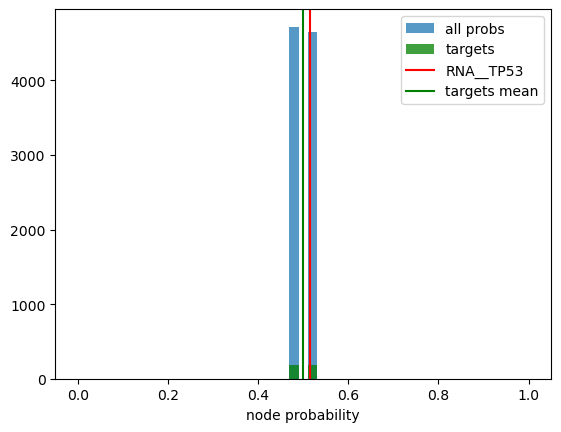

In [77]:
bins = np.linspace(0,1,50)
dens = False

plt.figure()
plt.hist(res.prob, bins=bins, alpha=0.75, density=dens, label='all probs')
#for targ in targs: 
#    plt.axvline(res[lambda x: x.node_name == targ].prob.item(), c='g')
#plt.axvline(res[lambda x: x.node_name.isin(targs)].prob.mean().item(), c='y')
plt.hist(res[lambda x: x.node_name.isin(targs)].prob, color='g', bins=bins, alpha=0.75, density=dens, label='targets')
plt.axvline(res[lambda x: x.node_name == 'RNA__P04637'].prob.item(), c='r', label='RNA__TP53')
plt.axvline(res[lambda x: x.node_name.isin(targs)].prob.mean(), c='g', label='targets mean')
plt.xlabel('node probability')
plt.legend()
plt.show()

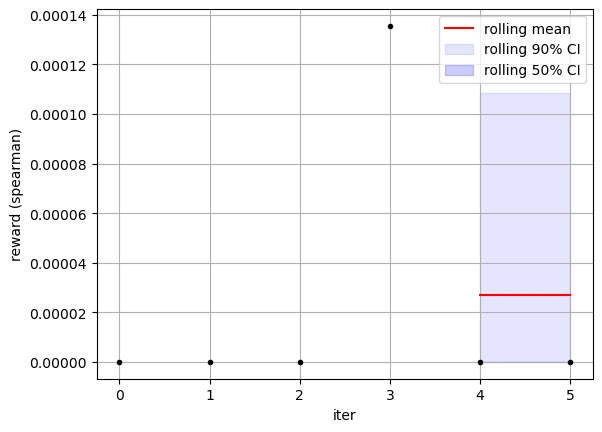

In [76]:
window=5
tmp = pd.DataFrame({'reward':result_dict['reward_scaler'].rewards})
tmp = tmp.assign(rm = tmp.rolling(window=window).mean(), 
                 rs = tmp.rolling(window=window).std(),
                 q05 = tmp.rolling(window=window).quantile(q=0.05),
                 q25 = tmp.rolling(window=window).quantile(q=0.25), 
                 q75 = tmp.rolling(window=window).quantile(q=0.75), 
                 q95 = tmp.rolling(window=window).quantile(q=0.95), 
                 )

plt.figure()
plt.plot(result_dict['reward_scaler'].rewards, 'k.')
plt.plot(tmp.rm, 'r-', label='rolling mean')
plt.fill_between(range(len(tmp.rm)), tmp.q95, tmp.q05, color='b', alpha=0.1, label='rolling 90% CI')
plt.fill_between(range(len(tmp.rm)), tmp.q75, tmp.q25, color='b', alpha=0.2, label='rolling 50% CI')
plt.legend()
plt.grid()
plt.xlabel('iter')
plt.ylabel('reward (spearman)')
plt.show()

In [93]:
z = result_dict['x'].detach().cpu().numpy() 
reducer = umap.UMAP(n_neighbors=15, min_dist=0.1)
u = reducer.fit_transform(z)

zres = pd.DataFrame(u, columns=['u0', 'u1']).assign(prob=result_dict['node_prob'])

KeyboardInterrupt: 

In [28]:
plt.figure()
sbn.scatterplot(x='u0', y='u1', hue='prob', data=zres, alpha=0.8)
plt.show()

NameError: name 'zres' is not defined

<Figure size 640x480 with 0 Axes>

In [29]:
result_dict = torch.load('../../processed_data/rl_results_dict.pt')

p = np.array(result_dict['node_prob'])
env = result_dict['env']

result_dict.keys()

dict_keys(['state_dict', 'node_prob', 'reward_scaler', 'args', 'x', 'actor', 'data', 'model_kwargs', 'training_kwargs', 'env'])

In [30]:

env.model_kwargs['checkpoint'] = False
env.train_dataset.root = '../../data/all/'
env.val_dataset.root = '../../data/all/'

n = 5

policy_perf = []
for i in range(n): 
        action = torch.tensor(np.random.binomial(n=1, p=p), dtype=torch.float32)
        policy_perf.append( env.run(action) )

rand_perf = []
for i in range(n): 
    p_ = np.mean(p)*np.ones((len(p),))
    action = torch.tensor(np.random.binomial(n=1, p=p_), dtype=torch.float32)
    rand_perf.append( env.run(action) )

env.batch_size = 100 # probably have to adjust this 
baseline_perf = []
for i in range(n):      
        action = torch.ones((len(p), ), dtype=torch.float32)
        baseline_perf.append( env.run(action) )

res = pd.DataFrame({'policy':['ppo']*n + ['all']*n + ['random']*n, 'perf':policy_perf + baseline_perf + rand_perf})

plt.figure()
sbn.boxplot(x='policy', y='perf', data=res)
plt.show()


KeyboardInterrupt: 

In [17]:
res

,action,perf
0,policy,0.387719
1,policy,0.392071
2,policy,0.167701
3,policy,0.412015
4,policy,0.410178
5,baseline,0.395513
6,baseline,0.377342
7,baseline,0.172750
8,baseline,0.403196
9,baseline,0.375111


In [225]:
rand_perf = []
for i in range(n): 
    p_ = np.mean(p)*np.ones((len(p),))
    action = torch.tensor(np.random.binomial(n=1, p=p_), dtype=torch.float32)
    rand_perf.append( env.run(action) )

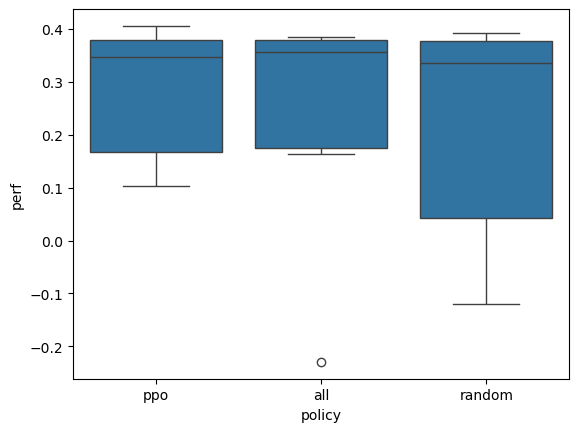

In [228]:
res = pd.DataFrame({'policy':['ppo']*n + ['all']*n + ['random']*n, 'perf':policy_perf + baseline_perf + rand_perf})

plt.figure()
sbn.boxplot(x='policy', y='perf', data=res)
plt.show()


progress: 1/10


progress: 2/10: 6/25 | train loss: 8.8 || val perf: 0.30651
progress: 3/10: 9/25 | train loss: 4.3 || val perf: 0.088973
progress: 4/10: 16/25 | train loss: 6.6 || val perf: -0.033
progress: 5/10: 9/25 | train loss: 12.3 || val perf: 0.373
progress: 6/10: 8/25 | train loss: 5.8 || val perf: 0.354956
progress: 7/10: 12/25 | train loss: 8.4 || val perf: 0.3436
progress: 8/10: 12/25 | train loss: 10.7 || val perf: 0.318
progress: 9/10: 14/25 | train loss: 13.4 || val perf: 0.3228
progress: 10/10 8/25 | train loss: 818.5 || val perf: 0.1075166


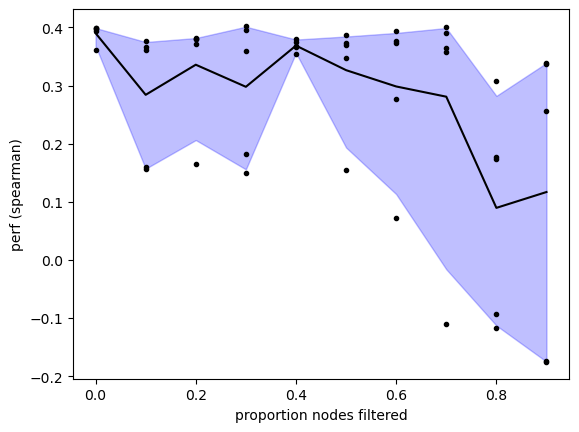

In [223]:
# this should really be done with a test dataset ... 

env.train_dataset.root = '../../processed_data/'
env.val_dataset.root = '../../processed_data/'

qs=np.linspace(0., 0.9, 10)
perfs = []

for i,q in enumerate(qs): 
    print(f'progress: {i+1}/{len(qs)}')
    repls = []
    for j in range(5): 
        t = np.quantile(p, q=[q])[0]
        action = torch.tensor((1.*(p>t)), dtype=torch.float32)
        repls.append( env.run(action) )
    perfs.append(repls)

p_mean = [np.mean(p) for p in perfs]
p_q05 = [np.quantile(p, q=[0.05])[0] for p in perfs]
p_q95 = [np.quantile(p, q=[0.95])[0] for p in perfs]

plt.figure()
plt.plot(qs, p_mean, 'k-')
plt.fill_between(qs, p_q05, p_q95, color='b', alpha=0.25)

for i in range(5): 
    plt.plot(qs, [p[i] for p in perfs], 'k.')

plt.ylabel('perf (spearman)')
plt.xlabel('proportion nodes filtered')
plt.show()